In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from prophet.plot import plot_components
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
from statsmodels.graphics import tsaplots
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
from sklearn.preprocessing import MinMaxScaler

# Suppress warnings
warnings.filterwarnings('ignore')

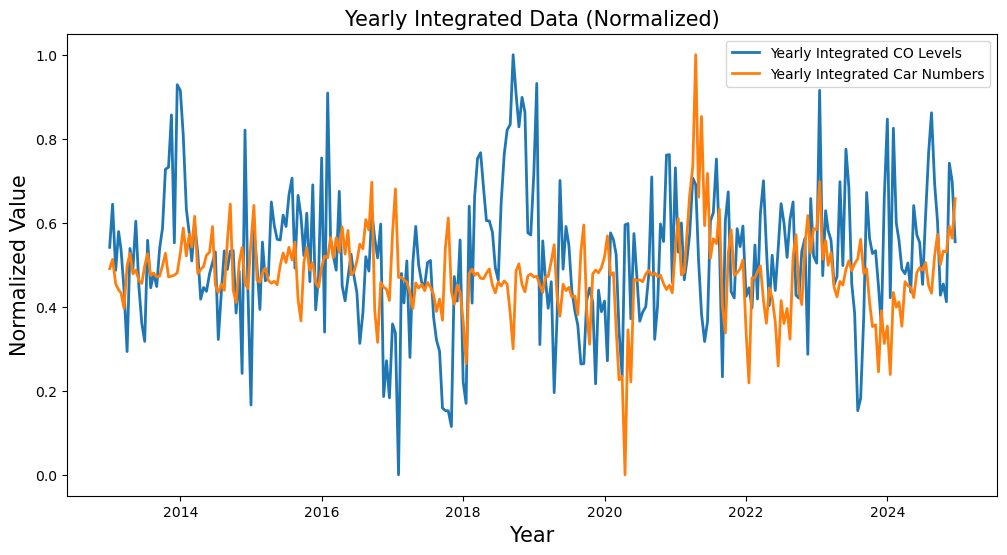

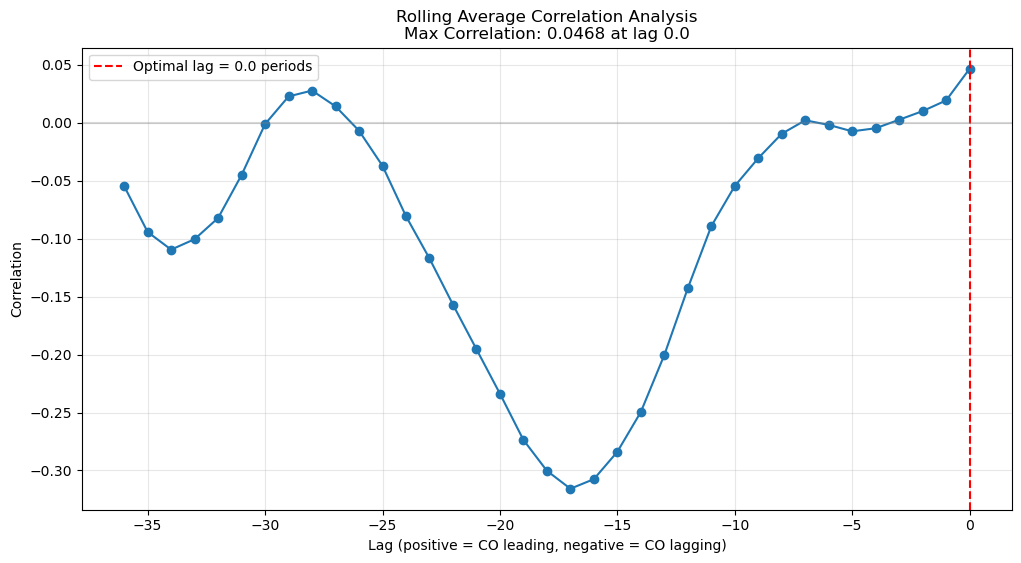

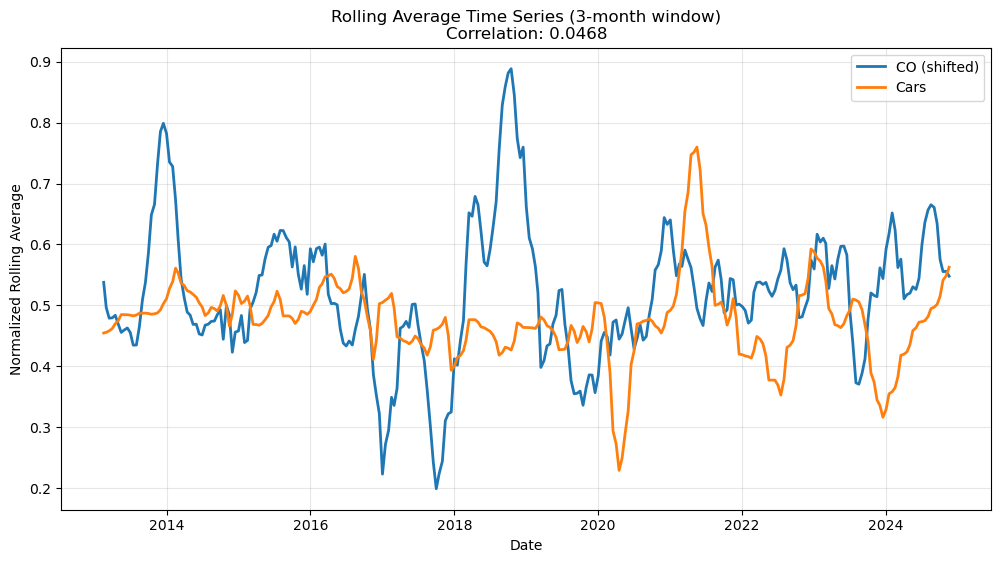


Rolling Average Analysis Summary:
Window size: 6 periods (3.0 months)
Optimal lag: 0.0 periods (0.0 months)
Maximum correlation: 0.0468


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from prophet.plot import plot_components
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
from statsmodels.graphics import tsaplots
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
from sklearn.preprocessing import MinMaxScaler
# Suppress specific statsmodels warnings about frequency
warnings.filterwarnings('ignore', 'No frequency information was provided')
warnings.filterwarnings('ignore', 'No supported index is available')
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# ---------------------
# 1. Load Data and Filter
# ---------------------
# Load the datasets
df_air = pd.read_csv('data/co_avg.csv', parse_dates=['date'])
df_cars = pd.read_csv('data/cars_transformed.csv', parse_dates=['date'])

# Set the Date column as the index
df_air.set_index('date', inplace=True)
df_cars.set_index('date', inplace=True)

# Extract the relevant columns
dfCO = df_air[['CO']]
dfCars = df_cars[['car_num']]

# Filter data from 2012 to end of 2024
dfCO = dfCO[(dfCO.index >= '2012-01-01') & (dfCO.index <= '2024-12-31')]
dfCars = dfCars[(dfCars.index >= '2012-01-01') & (dfCars.index <= '2024-12-31')]

yearly_integration_co = dfCO.diff(periods=24).dropna()
yearly_integration_cars = dfCars.diff(periods=24).dropna()

# Ensure both series have the same index
common_index = yearly_integration_co.index.intersection(yearly_integration_cars.index)
yearly_integration_co = yearly_integration_co.loc[common_index]
yearly_integration_cars = yearly_integration_cars.loc[common_index]

# ---------------------
# 2. Normalize the Data (Scaling to [0, 1])
# ---------------------
scaler = MinMaxScaler()
yearly_integration_co_scaled = scaler.fit_transform(yearly_integration_co)
yearly_integration_cars_scaled = scaler.fit_transform(yearly_integration_cars)

# Create DataFrame with both series
combined_df = pd.DataFrame({
    'co': yearly_integration_co_scaled.flatten(),
    'cars': yearly_integration_cars_scaled.flatten()
}, index=common_index)

# Plot the normalized data
plt.figure(figsize=(12, 6))
plt.plot(yearly_integration_co.index, yearly_integration_co_scaled, label='Yearly Integrated CO Levels', linewidth=2)
plt.plot(yearly_integration_cars.index, yearly_integration_cars_scaled, label='Yearly Integrated Car Numbers', linewidth=2)
plt.title("Yearly Integrated Data (Normalized)", fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Normalized Value', fontsize=15)
plt.legend()
plt.show()

# ---------------------
# 3. Apply Rolling Average Transformation
# ---------------------
window = 6  # 3 months of bi-monthly data
roll_co = combined_df['co'].rolling(window=window, center=True).mean().dropna()
roll_cars = combined_df['cars'].rolling(window=window, center=True).mean().dropna()

# ---------------------
# 4. Find Optimal Lag
# ---------------------
def find_max_correlation(series1, series2, max_lag=36):
    """Find maximum correlation and optimal lag"""
    lag_range = range(-max_lag, 1)
    correlations = []
    for lag in lag_range:
        if lag == 0:
            corr = series1.corr(series2)
        else:
            corr = series1.shift(lag).corr(series2)
        correlations.append((lag, corr, abs(corr)))
    
    corr_df = pd.DataFrame(correlations, columns=['lag', 'correlation', 'abs_correlation'])
    optimal_lag = corr_df.loc[corr_df['correlation'].idxmax()]
    return optimal_lag, corr_df

# Calculate optimal lag
optimal_lag, corr_df = find_max_correlation(roll_co, roll_cars)

# ---------------------
# 5. Visualize Results
# ---------------------
# Plot correlation analysis
plt.figure(figsize=(12, 6))
plt.plot(corr_df['lag'], corr_df['correlation'], marker='o')
plt.axvline(x=optimal_lag['lag'], color='red', linestyle='--', 
           label=f"Optimal lag = {optimal_lag['lag']} periods")
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
plt.title(f'Rolling Average Correlation Analysis\nMax Correlation: {optimal_lag["correlation"]:.4f} at lag {optimal_lag["lag"]}')
plt.xlabel('Lag (positive = CO leading, negative = CO lagging)')
plt.ylabel('Correlation')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Plot time series with optimal lag
plt.figure(figsize=(12, 6))
shifted_co = roll_co.shift(int(optimal_lag['lag']))
plt.plot(shifted_co.index, shifted_co, label='CO (shifted)', linewidth=2)
plt.plot(roll_cars.index, roll_cars, label='Cars', linewidth=2)
plt.title(f'Rolling Average Time Series (3-month window)\nCorrelation: {optimal_lag["correlation"]:.4f}')
plt.xlabel('Date')
plt.ylabel('Normalized Rolling Average')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print summary
print(f"\nRolling Average Analysis Summary:")
print(f"Window size: {window} periods ({window/2} months)")
print(f"Optimal lag: {optimal_lag['lag']} periods ({optimal_lag['lag']/2:.1f} months)")
print(f"Maximum correlation: {optimal_lag['correlation']:.4f}")





We ca see the best outcome is when we shift the car data 7 months forward, this achieves ~0.6 correlation on the Ranana_Ahuza station dataset

17:02:04 - cmdstanpy - INFO - Chain [1] start processing


Train shape: (265, 1)
Test shape: (47, 1)

--- Prophet without exogenous variables ---


17:02:04 - cmdstanpy - INFO - Chain [1] done processing
17:02:04 - cmdstanpy - INFO - Chain [1] start processing


Prophet without exogenous variables - MSE: 0.0075, RMSE: 0.0867, MAE: 0.0746

--- Prophet with exogenous variables (cars) ---


17:02:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet with exogenous variables - MSE: 0.0076, RMSE: 0.0873, MAE: 0.0751

--- Performance Comparison ---
Performance improvement with exogenous variables: -1.36%
Average confidence interval width - Without exog: 0.1820, With exog: 0.1820
Confidence interval width reduction: 0.00%


,Prophet without Cars,Prophet with Cars,Improvement (%)
Metric,,,
MSE,0.0075,0.0076,-1.36%
RMSE,0.0867,0.0873,-0.68%
MAE,0.0746,0.0751,-0.72%
CI Width,0.1820,0.1820,0.00%
Training Size,265,265,-
Test Size,47,47,-


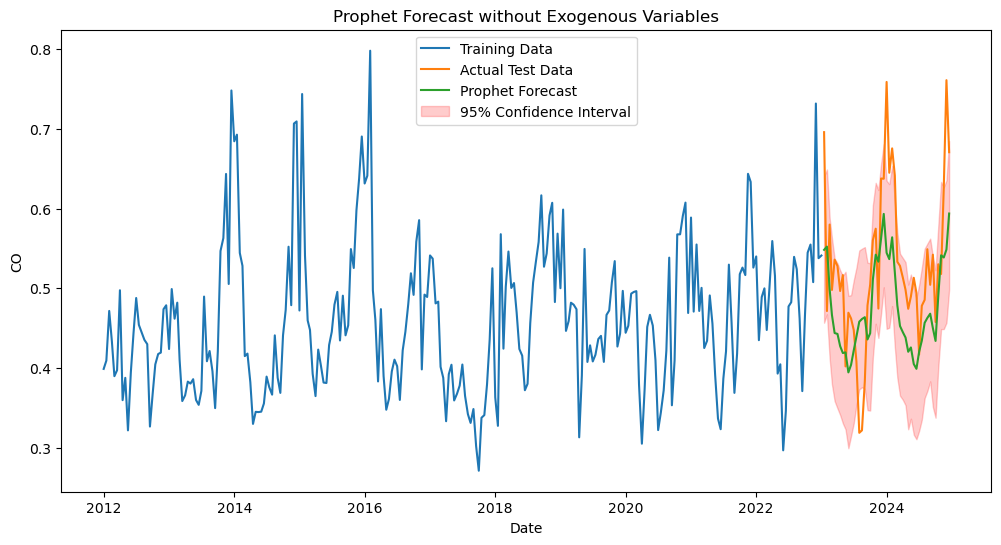

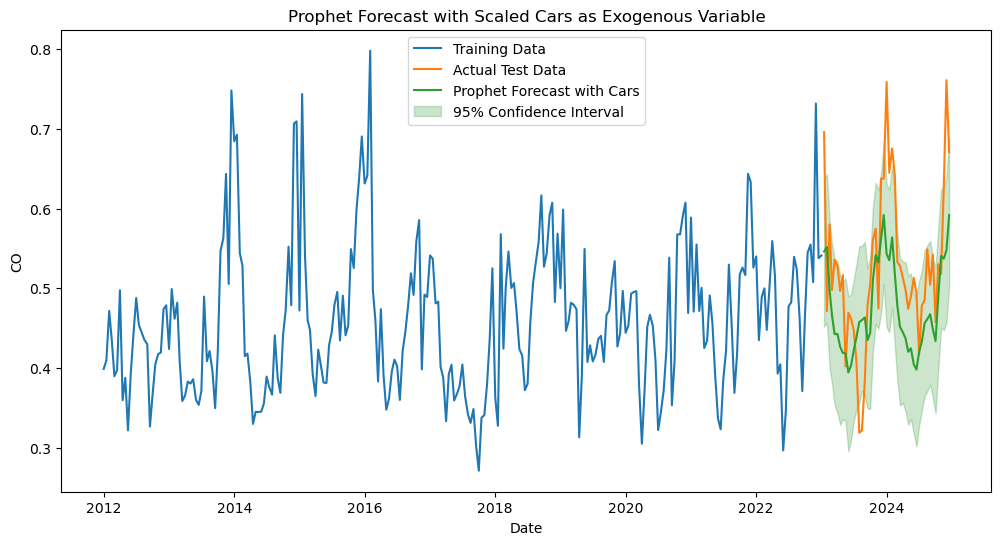

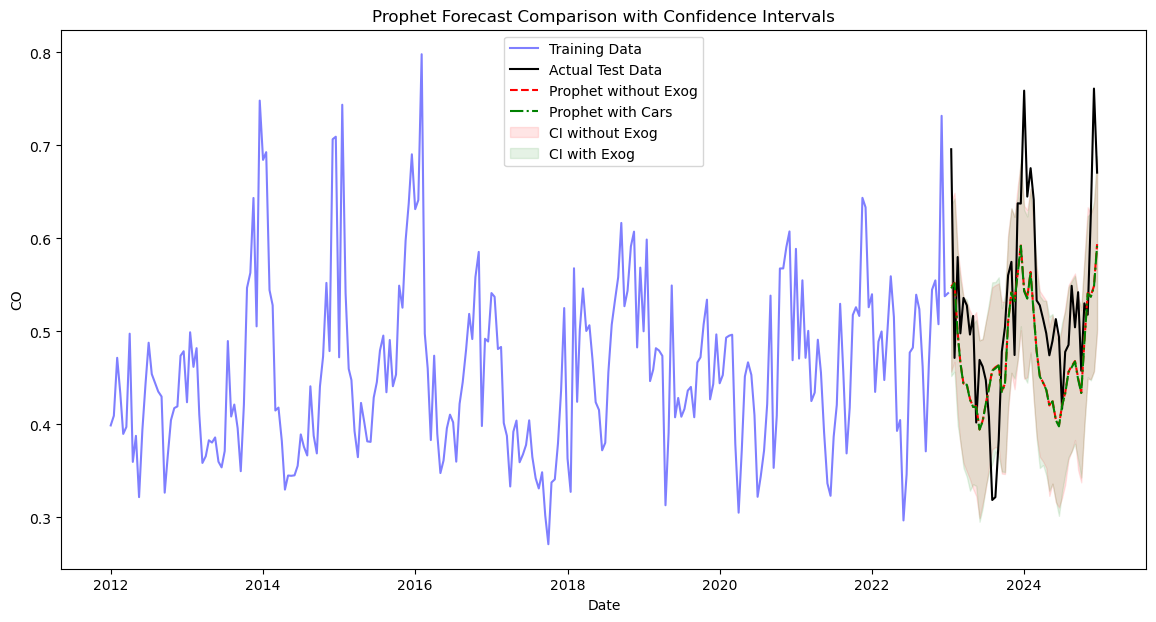

<Figure size 1200x1000 with 0 Axes>

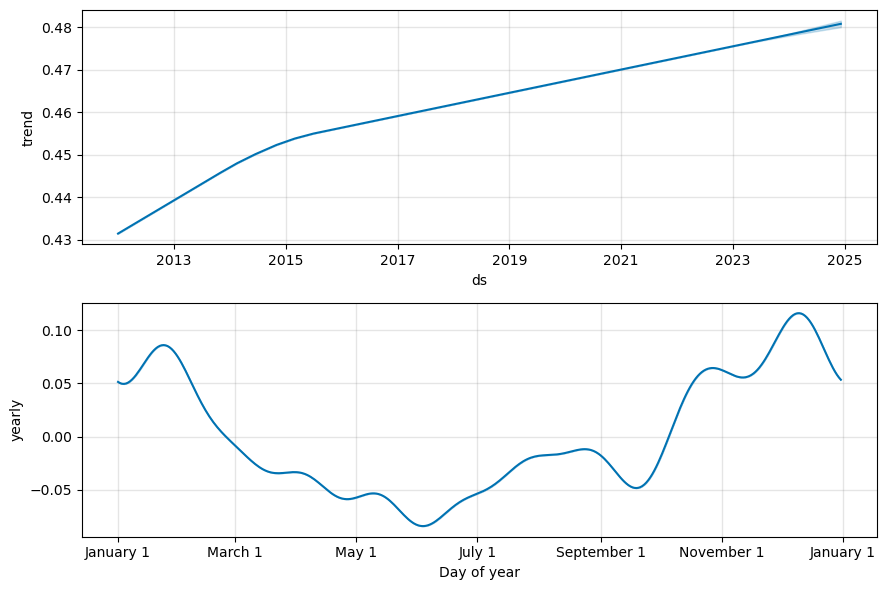

<Figure size 1200x1000 with 0 Axes>

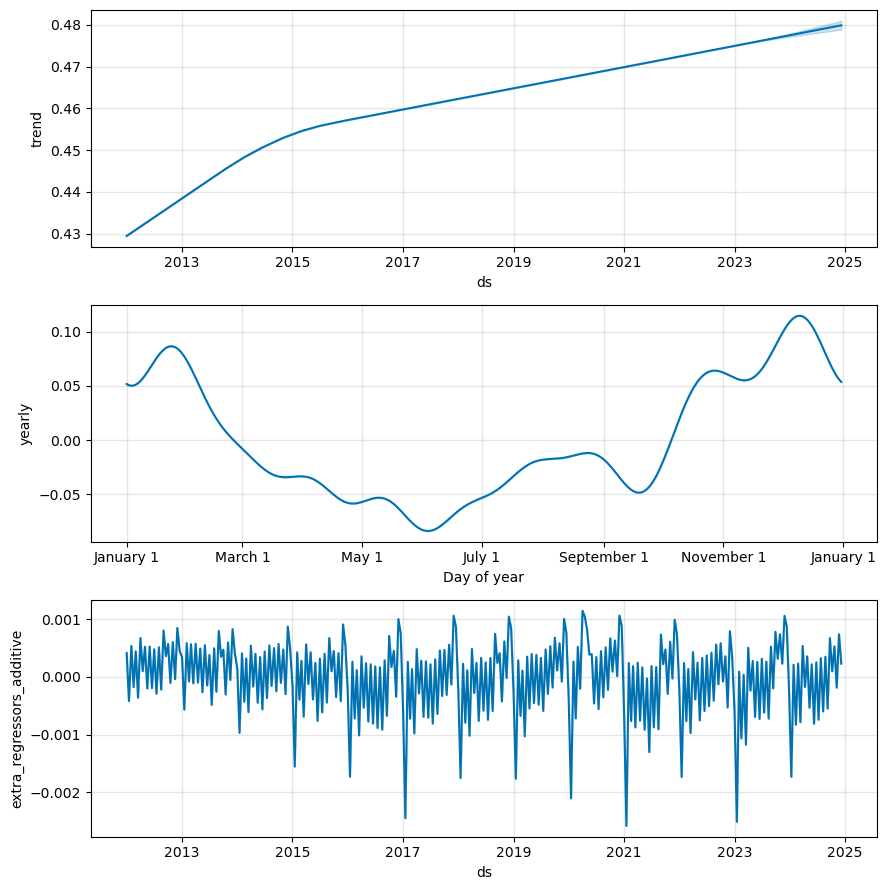

In [67]:

# ---------------------
# 1. Load Data and Filter
# ---------------------
# Load the datasets
df_air = pd.read_csv('data/co_avg.csv', parse_dates=['date'])
df_cars = pd.read_csv('data/cars_transformed.csv', parse_dates=['date'])
# Set the Date column as the index
df_air.set_index('date', inplace=True)
df_cars.set_index('date', inplace=True)

# Extract the relevant columns
dfCO = df_air[['CO']]
dfCars = df_cars[['car_num']]

# Filter data from 2012 to end of 2024
dfCO = dfCO[(dfCO.index >= '2012-01-01') & (dfCO.index <= '2024-12-31')]
dfCars = dfCars[(dfCars.index >= '2012-01-01') & (dfCars.index <= '2024-12-31')]


# Align the data and handle NaN values
common_index = dfCO.index.intersection(dfCars.dropna().index)
dfCO = dfCO.loc[common_index]
dfCars = dfCars.loc[common_index]
# Interpolate any remaining missing values
dfCO = dfCO.interpolate(method='linear')
dfCars = dfCars.interpolate(method='linear')
# Recalculate train/test split after alignment
train_size = int(len(dfCO) * 0.85)
train = dfCO.iloc[:train_size]
test = dfCO.iloc[train_size:]

# Also split the cars data according to the same indices
train_cars = dfCars.iloc[:train_size]
test_cars = dfCars.iloc[train_size:]

print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Scale the exogenous data (car_num) using MinMaxScaler
scaler = MinMaxScaler()
dfCars_scaled = pd.DataFrame(
    scaler.fit_transform(dfCars),
    index=dfCars.index,
    columns=['car_num']
)

# Split the scaled cars data
train_cars_scaled = dfCars_scaled.iloc[:train_size]
test_cars_scaled = dfCars_scaled.iloc[train_size:]

# ---------------------
# 2. Prophet Implementation
# ---------------------

# Format data for Prophet (requires columns 'ds' for date and 'y' for target)
def prepare_prophet_data(df, exog=None):
    # Reset index to get Date as a column
    df_reset = df.reset_index()
    
    # Create a dataframe for Prophet
    df_prophet = pd.DataFrame()
    df_prophet['ds'] = df_reset['date']
    df_prophet['y'] = df_reset['CO']
    
    # Add exogenous variable if provided
    if exog is not None:
        exog_reset = exog.reset_index()
        df_prophet['cars'] = exog_reset['car_num']
    
    return df_prophet

# Without exogenous variables
print("\n--- Prophet without exogenous variables ---")
# Prepare training data
train_prophet = prepare_prophet_data(train)

# Create and fit the model
model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model_prophet.fit(train_prophet)

# Create a dataframe for future predictions that includes the test period
future = model_prophet.make_future_dataframe(periods=len(test), freq='15D')

# Generate predictions
forecast = model_prophet.predict(future)

# Extract predictions for the test period
predictions_prophet = forecast.iloc[-len(test):]['yhat'].values
# Extract confidence intervals
lower_bound = forecast.iloc[-len(test):]['yhat_lower'].values
upper_bound = forecast.iloc[-len(test):]['yhat_upper'].values

# Calculate performance metrics
mse_prophet = mean_squared_error(test['CO'].values, predictions_prophet)
rmse_prophet = np.sqrt(mse_prophet)
mae_prophet = mean_absolute_error(test['CO'].values, predictions_prophet)

print(f"Prophet without exogenous variables - MSE: {mse_prophet:.4f}, RMSE: {rmse_prophet:.4f}, MAE: {mae_prophet:.4f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['CO'], label='Training Data')
plt.plot(test.index, test['CO'], label='Actual Test Data')
plt.plot(test.index, predictions_prophet, label='Prophet Forecast')
# Add confidence intervals
plt.fill_between(test.index, lower_bound, upper_bound, color='red', alpha=0.2, label='95% Confidence Interval')
plt.title('Prophet Forecast without Exogenous Variables')
plt.xlabel('Date')
plt.ylabel('CO')
plt.legend()


# With exogenous variables (cars)
print("\n--- Prophet with exogenous variables (cars) ---")
# Prepare training data with scaled exogenous variable
train_prophet_exog = prepare_prophet_data(train, train_cars_scaled)

# Create and fit the model
model_prophet_exog = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
# Add regressor
model_prophet_exog.add_regressor('cars')
model_prophet_exog.fit(train_prophet_exog)

# Create a dataframe for future predictions
future_exog = model_prophet_exog.make_future_dataframe(periods=len(test), freq='15D')
# Add the scaled exogenous variable values for both training and test periods
future_cars = pd.concat([train_cars_scaled, test_cars_scaled])
future_exog['cars'] = future_cars['car_num'].values

# Generate predictions
forecast_exog = model_prophet_exog.predict(future_exog)

# Extract predictions for the test period
predictions_prophet_exog = forecast_exog.iloc[-len(test):]['yhat'].values
# Extract confidence intervals for the model with exogenous variables
lower_bound_exog = forecast_exog.iloc[-len(test):]['yhat_lower'].values
upper_bound_exog = forecast_exog.iloc[-len(test):]['yhat_upper'].values

# Calculate performance metrics
mse_prophet_exog = mean_squared_error(test['CO'].values, predictions_prophet_exog)
rmse_prophet_exog = np.sqrt(mse_prophet_exog)
mae_prophet_exog = mean_absolute_error(test['CO'].values, predictions_prophet_exog)

print(f"Prophet with exogenous variables - MSE: {mse_prophet_exog:.4f}, RMSE: {rmse_prophet_exog:.4f}, MAE: {mae_prophet_exog:.4f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['CO'], label='Training Data')
plt.plot(test.index, test['CO'], label='Actual Test Data')
plt.plot(test.index, predictions_prophet_exog, label='Prophet Forecast with Cars')
# Add confidence intervals
plt.fill_between(test.index, lower_bound_exog, upper_bound_exog, color='green', alpha=0.2, label='95% Confidence Interval')
plt.title('Prophet Forecast with Scaled Cars as Exogenous Variable')
plt.xlabel('Date')
plt.ylabel('CO')
plt.legend()


# Compare results
print("\n--- Performance Comparison ---")
improvement = ((mse_prophet - mse_prophet_exog) / mse_prophet) * 100
print(f"Performance improvement with exogenous variables: {improvement:.2f}%")
# Compare confidence interval widths
ci_width_without = np.mean(upper_bound - lower_bound)
ci_width_with = np.mean(upper_bound_exog - lower_bound_exog)
print(f"Average confidence interval width - Without exog: {ci_width_without:.4f}, With exog: {ci_width_with:.4f}")
print(f"Confidence interval width reduction: {((ci_width_without - ci_width_with) / ci_width_without) * 100:.2f}%")

# Create results comparison table
results_data = {
    'Metric': ['MSE', 'RMSE', 'MAE', 'CI Width', 'Training Size', 'Test Size'],
    'Prophet without Cars': [
        f"{mse_prophet:.4f}",
        f"{rmse_prophet:.4f}",
        f"{mae_prophet:.4f}",
        f"{ci_width_without:.4f}",
        len(train),
        len(test)
    ],
    'Prophet with Cars': [
        f"{mse_prophet_exog:.4f}",
        f"{rmse_prophet_exog:.4f}",
        f"{mae_prophet_exog:.4f}",
        f"{ci_width_with:.4f}",
        len(train),
        len(test)
    ],
    'Improvement (%)': [
        f"{((mse_prophet - mse_prophet_exog) / mse_prophet * 100):.2f}%",
        f"{((rmse_prophet - rmse_prophet_exog) / rmse_prophet * 100):.2f}%",
        f"{((mae_prophet - mae_prophet_exog) / mae_prophet * 100):.2f}%",
        f"{((ci_width_without - ci_width_with) / ci_width_without * 100):.2f}%",
        "-",
        "-"
    ]
}

results_df = pd.DataFrame(results_data)
results_df.set_index('Metric', inplace=True)

display(results_df)

# Plot comparison
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['CO'], label='Training Data', color='blue', alpha=0.5)
plt.plot(test.index, test['CO'], label='Actual Test Data', color='black')
plt.plot(test.index, predictions_prophet, label='Prophet without Exog', color='red', linestyle='--')
plt.plot(test.index, predictions_prophet_exog, label='Prophet with Cars', color='green', linestyle='-.')
# Add confidence intervals for both models
plt.fill_between(test.index, lower_bound, upper_bound, color='red', alpha=0.1, label='CI without Exog')
plt.fill_between(test.index, lower_bound_exog, upper_bound_exog, color='green', alpha=0.1, label='CI with Exog')
plt.title('Prophet Forecast Comparison with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('CO')
plt.legend()


# Component plots for better understanding
plt.figure(figsize=(12, 10))
fig1 = model_prophet.plot_components(forecast)


plt.figure(figsize=(12, 10))
fig2 = model_prophet_exog.plot_components(forecast_exog)
